# はじめに

このノートブックおよび元のリポジトリは、[waifu-diffusion](https://github.com/harubaru/waifu-diffusion)ならびに[sd-scripts](https://github.com/kohya-ss/sd-scripts)から非常に多くの着想を得て（つまりぱくって）作られています。両リポジトリの作者であるharu氏とkohya-ss氏に感謝いたします。

じゃあ何がこの2つと違うんだよ、というともう一方のノートブックを見てください。

**PythonやlinuxのCUIに慣れていない人が動かすことは想定していません。またdiffusersをckptにしたりwebuiで使う方法といった親切な案内はありません。アンチDreamboothなのでDreamboothはありません。でもこの学習はDreamboothの方があってるような気もします。**

# やること

顔部分のみを学習させることによって、スタイルだけを抽出します。mimic的な目的以外にもキャラクターの顔部分だけ学ばせて好きなキャラクターに好きな衣装を着せるようにする、といったこともできます（普通のファインチューニングでもできますけど、元の衣装やポーズなどがでてきてしまいがち）。

学習用画像（hoge.png, piyo.jpg, ...）とその説明文(hoge.caption, piyo.caption, ...)がドライブに必要です(pngしか確認していないのでpng推奨)。説明文用意するには[これ](https://github.com/toriato/stable-diffusion-webui-wd14-tagger)使えばいいんじゃないかな。(mimicの場合、説明文はあまり重要ではないと思います。)

コードを非表示にして、決められた枠に設定項目うちこんで何も考えずに再生ボタンを押してください見たいなやつきらいなのでやりません。

NVIDIA T4でテストしています。

In [ ]:
!nvidia-smi

Mon Jan 30 01:18:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 環境構築等

ドライブのマウントを前提とする。

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


※※ドライブ直下にリポジトリがダウンロードされます。

In [ ]:
!git clone https://github.com/laksjdjf/sd-trainer.git

Cloning into 'sd-trainer'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 126 (delta 56), reused 19 (delta 7), pack-reused 0
Receiving objects: 100% (126/126), 54.06 KiB | 3.00 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [1]:
%cd /content/drive/MyDrive/sd-trainer/

/content/drive/MyDrive/sd-trainer


In [ ]:
#!git pull origin main #update用

From https://github.com/laksjdjf/sd-trainer
 * branch            main       -> FETCH_HEAD
Updating afb3112..5f9f467
Fast-forward
 lora/lora.py | 2 +-
 main.py      | 3 +++
 2 files changed, 4 insertions(+), 1 deletion(-)


In [9]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 104.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 

xformersのインストール、T4以外でうまくいくか分からない。A100だとだめでした。

In [3]:
#インストールコマンドはhttps://github.com/Linaqruf/kohya-trainerから持ってきました
!pip -qqqq install -U -I --no-deps https://github.com/camenduru/stable-diffusion-webui-colab/releases/download/0.0.15/xformers-0.0.15.dev0+189828c.d20221207-cp38-cp38-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.9/102.9 MB 10.1 MB/s eta 0:00:00


hugging faceのログインが必要なモデルを使う場合はログインする。（Waifu Diffusionならいらない）

In [ ]:
from huggingface_hub import login
login()

# 前処理

画像を[Aspect ratio bucketing](https://github.com/NovelAI/novelai-aspect-ratio-bucketing)により前処理します。引数は良い感じに変えてくださいね（特にデータセットの場所と保存先）。このノートブックでは、画像とテキストがあるディレクトリを../dataset、学習プログラムが利用する前処理済みデータを../dataset_preprocessに入れることを想定してコードを書いています。

詳しい説明

Aspect ratio bucketingはNovelAIが考えた学習手法です。Stable Diffusionのモデルは64の倍数であれば、どんな解像度にも（結果はどうあれ）対応できるのですが、複数の画像を並列計算する場合は解像度を合わせなければいけません。そこで、まずいくつかの解像度候補（bucket）を選び、学習画像を一番近いアスペクト比のbucketにリサイズします。そして学習する際は同じbucketのデータを取り出すようにします。これにより複数のアスペクト比を持つデータセットに対応できるようになります。

--resolutionは正方形bucketの解像度であり、全てのbucketはそのピクセル数を越えないように作られます。

--min_lengthはbucketの最小長です。maxの方は同様

--max_ratioはアスペクト比最大値（逆数が最小値）になります。この範囲を越えるbucketは作らず、極端なアスペクト比の画像は学習用データセットから取り除かれます。

In [ ]:
!python preprocess/bucketing.py \
--input_dir "../dataset" \
--output_dir "../dataset_preprocess" \
--resolution 768 \
--min_length 512 \
--max_length 1024 \
--max_ratio 2 \
--threads 2

[[ 512 1024]
 [ 576 1024]
 [ 576  960]
 [ 640  896]
 [ 704  832]
 [ 768  768]
 [ 832  704]
 [ 896  640]
 [ 960  576]
 [1024  576]
 [1024  512]]
100% 251/251 [01:04<00:00,  3.91it/s]
(640, 896): 170個
(704, 832): 6個
(576, 960): 5個
(768, 768): 10個
(896, 640): 22個
(1024, 576): 12個
(512, 1024): 13個
(832, 704): 12個
(576, 1024): 1個


アニメイラストだったらだいたい幅：高さが0.7:1くらいの解像度が一番多いと思います。

画像をVAEにより潜在変数にします。あらかじめ計算をやっておくことで、2エポック以上なら学習が早くなります。モデルは学習対象を選んだ方が確実ですが、別のモデルでも割と問題なさそうです。

In [ ]:
!python preprocess/latent.py \
--directory ../dataset_preprocess/ \
--output_path ../dataset_preprocess/ \
--model "hakurei/waifu-diffusion" \
--batch_size 4

(640, 896)
100% 170/170 [00:48<00:00,  3.52it/s]
(704, 832)
100% 6/6 [00:01<00:00,  5.10it/s]
(576, 960)
100% 5/5 [00:01<00:00,  4.80it/s]
(768, 768)
100% 10/10 [00:02<00:00,  4.32it/s]
(896, 640)
100% 22/22 [00:05<00:00,  3.99it/s]
(1024, 576)
100% 12/12 [00:03<00:00,  3.53it/s]
(512, 1024)
100% 13/13 [00:02<00:00,  4.50it/s]
(832, 704)
100% 12/12 [00:03<00:00,  3.52it/s]
(576, 1024)
100% 1/1 [00:00<00:00, 32.48it/s]


説明文ファイル(hoge.caption)を前処理した潜在変数がある場所と同じ場所に置く。

```
dataset_preprocess/
            |ーbuckets.json (bucketing.pyで作られるメタデータ)
            |ーhoge.npy
            |ーhoge.caption
            |ーpiyo.npy
            |ーpiyo.caption
            ・
            ・
```

みたいになってればおｋ（npy,caption以外に無駄ファイルがあってもおｋ）



In [ ]:
#これをするかどうかは人によると思います(手動でやってもおｋ)。.txtで説明文を持っている場合はよくわからないけどlinux 拡張子 一括変更とかで検索してください。
#!cp ../dataset/*.caption ../dataset_preprocess/

# 顔の位置を抽出
顔の位置を抽出します。今回の方法では表情だけでなく髪型くらいまで学習します。
[nagadomi氏の重みファイル](https://github.com/nagadomi/lbpcascade_animeface)を利用します。

顔部分を1.00、顔以外の部分を0.05としたnumpy配列をnpz方式で保存します。顔以外も0.05にするのは背景を完全無視することを避けるためです。ここまではcloneofsimo氏の実装と同じですが、正規化(mask = mask / mask.mean())はしません。これをすると、一部のピクセルだけが大きな数値になって、lossがnanしてしまうことを確認しています。（学習率を下げればいいのかもしれないが。）

In [ ]:
!wget https://raw.githubusercontent.com/nagadomi/lbpcascade_animeface/master/lbpcascade_animeface.xml

--2023-01-30 01:00:26--  https://raw.githubusercontent.com/nagadomi/lbpcascade_animeface/master/lbpcascade_animeface.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 246945 (241K) [text/plain]
Saving to: ‘lbpcascade_animeface.xml’

lbpcascade_animefac 100%[===================>] 241.16K  --.-KB/s    in 0.005s  

2023-01-30 01:00:27 (50.4 MB/s) - ‘lbpcascade_animeface.xml’ saved [246945/246945]



In [ ]:
#libpngの警告どうにかする方法誰か知りませんか？
!python preprocess/create_mask.py --path ../dataset_preprocess --output_path ../dataset_preprocess

  0% 0/251 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
  8% 21/251 [00:06<00:52,  4.38it/s]libpng warning: iCCP: known incorrect sRGB profile
 14% 36/251 [00:09<00:44,  4.86it/s]libpng warning: iCCP: known incorrect sRGB profile
 20% 49/251 [00:12<00:44,  4.53it/s]libpng warning: iCCP: known incorrect sRGB profile
 30% 76/251 [00:16<00:33,  5.29it/s]libpng warning: iCCP: known incorrect sRGB profile
 39% 99/251 [00:19<00:21,  6.92it/s]libpng warning: iCCP: known incorrect sRGB profile
 40% 100/251 [00:19<00:26,  5.73it/s]libpng warning: iCCP: known incorrect sRGB profile
 49% 122/251 [00:23<00:27,  4.67it/s]libpng warning: iCCP: known incorrect sRGB profile
 58% 146/251 [00:27<00:20,  5.17it/s]libpng warning: iCCP: known incorrect sRGB profile
 60% 150/251 [00:27<00:12,  7.81it/s]libpng warning: iCCP: known incorrect sRGB profile
 63% 158/251 [00:29<00:22,  4.21i

最終的に、
```
dataset_preprocess/
            |ーbuckets.json (bucketing.pyで作られるメタデータ)
            |ーhoge.npy
            |ーhoge.npz
            |ーhoge.caption
            |ーpiyo.npy
            |ーpiyo.npz
            |ーpiyo.caption
            ・
            ・
```
みたいになっていればおｋ。（npy,npz,caption以外に無駄ファイルがあってもおｋ）


In [ ]:
!ls ../dataset_preprocess #確認用

## 訓練するぞ！訓練するぞ！訓練するぞ！徹底的に訓練するぞ！

**今回の学習はloraを推奨します。**

モデル、データセットの場所等を適切に選んでください。

--outputで指定したディレクトリ名で保存されます。（loraの場合は--output.pt)

--image_log 検証画像の保存先です。

--resolutionは今回の場合検証画像の生成解像度になります（訓練には影響しない）。

--loraは0にするとlora無しになります。nを指定するとrankがnのloraを学習します。負の数を入れたら何が起きるか分かりません。

--lrはloraだったら1e-4(rank=128みたいな大きい値だったら1e-3)、loraなしだったら5e-6、1e-5あたりを推奨します。

--step_range "a,b"と指定するとsampling stepの範囲をa～bに限定します。下のコードの例をみればなんとなくわかると思います

--wandb Weight&BiasというWebアプリで学習の様子が記録できます。使う場合はアカウントを作ってAPI keyを発行してください。

--v_prediction SD2-768系(baseがつかないやつ)を学習させる場合は設定してください

デフォルトの設定では、たしかVRAM使用量10GBくらいでした。**検証画像の生成時にVRAM使用量が上がるので注意してください。**RAMも標準だと7割くらい使っててかなり危ないラインですね。

**このコードのloraはkohya-ss氏の実装とすこ～しだけ違います。そのためこのリポジトリで作成したloraが使えなかった場合、まず私のリポジトリで教えてください。**

In [ ]:
#コマンドで実行するとプログレスバーがバグるの何とかする方法教えてください。
!python3 main.py \
--model "hakurei/waifu-diffusion" \
--dataset "../dataset_preprocess" \
--output "wd14_mimic" \
--image_log "image_logs" \
--resolution "768,768" \
--batch_size 2 \
--lr "1e-4" \
--epochs 10 \
--save_n_epochs 2 \
--lora 16 \
--step_range "0.0,0.7" \
--amp \
--mask \
--up_only \
--use_bucket 

# 学習したモデルを試してみる

一応生成用スクリプトも入れておきますが、基本的にはwebuiで使うことを前提にしています。

ckptにしたい場合⇒[convert_diffusers20_original_sd.py](https://github.com/kohya-ss/sd-scripts/blob/main/tools/convert_diffusers20_original_sd.py)

loraを使いたい場合⇒[sd-webui-additional-networks](https://github.com/kohya-ss/sd-webui-additional-networks)

**このコードのloraはkohya-ss氏の実装とすこ～しだけ違います。そのためこのリポジトリで作成したloraが使えなかった場合、まず私のリポジトリで教えてください。**

In [2]:
from diffusers import StableDiffusionPipeline
import torch

model_path = "hakurei/waifu-diffusion" #loraを使わなかった場合ここを学習したモデルにする
lora_path = "wd14_mimic.pt" #loraの場合ここに.ptのパス
use_lora = True #使う場合True
lora_rank = 16 #rank
up_only = True #up_onlyの場合

pipe = StableDiffusionPipeline.from_pretrained(model_path,safety_checker=None, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

#xformersのインストールをしている場合
pipe.enable_xformers_memory_efficient_attention()

#学習用のlora適用を無理やり実装しているだけで、マジの生成でこれをやるのはお勧めしない。
if use_lora:
    from lora.lora import LoRANetwork
    network = LoRANetwork(None, pipe.unet,lora_rank,"up_blocks" if up_only else "")
    network.requires_grad_(False)
    network.load_state_dict(torch.load(lora_path))
    network.to("cuda",torch.float16)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


create LoRA for U-Net: 108 modules.


  0%|          | 0/50 [00:00<?, ?it/s]

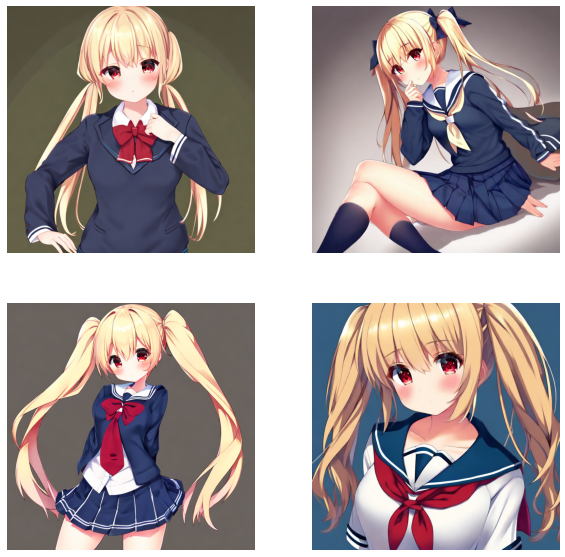

In [3]:
import matplotlib.pyplot as plt
prompt = "masterpiece,best quality,1girl,solo,blonde hair,twintails,red eyes,blush,school uniform" #金髪ツインテは正義
negative_prompt = "worst quality, low quality, medium quality, deleted, lowres, comic, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, blurry"

generator = torch.Generator("cuda").manual_seed(4545) #これにより、なんどやっても同じ画像になります。いらない場合は下のgeneratorの指定を消しましょう。
images = pipe([prompt]*4, height=768, width=768,negative_prompt=[negative_prompt]*4,num_inference_steps=50,guidance_scale=7.5,generator=generator)[0]

plt.figure(figsize=(10,10))
for i,image in enumerate(images):
    plt.subplot(2,2,i+1)
    plt.imshow(image)
    plt.axis('off')